<font size=7 face="courier">Experiment Source Code

# <font color="gray"> Set Up Notebook

import stuff

In [1]:
#!pip install powerlaw
# !pip install smart_open
# !pip install awswrangler
# !pip install deprecated
# !pip install nptyping

Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import braingeneers
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter1d
import glob
import pandas as pd

Load Data

In [3]:
braingeneers.set_default_endpoint("./data")
files = glob.glob('./data/ephys/2022-04-28-e-/derived/kilosort2/*')
print('Loading', files[0])
sd = read_phy_files(files[0])
metadata = ephys.load_metadata('2022-04-28-e-')

Loading ./data/ephys/2022-04-28-e-/derived/kilosort2/Trace_20220428_15_52_47_chip11350_curated.zip


# Helper Code

Get time and signal

In [31]:
def getTimeSignal(seconds, num_neurons=1):
    return np.arange(0,seconds*s_to_fs)/s_to_fs , np.zeros((seconds* s_to_fs, num_neurons))

create square wave

In [30]:
def squareWave( signal, time_s, phase_us=200, amp_mV=150):
    s_to_fs = 20000   #ms_to_fs=20
    us_to_fs = .02
    
    time_fs  = time_s * s_to_fs
    phase_fs =  int(phase_us * us_to_fs)   # Previously used ms #phase_fs = phase_ms * ms_to_fs
    half_phase_fs = int(phase_fs/2)
    
    signal[ time_fs:time_fs+half_phase_fs] = amp_mV
    signal[ time_fs+half_phase_fs : time_fs+half_phase_fs*2] = -amp_mV
    return signal


# Basic Pulse

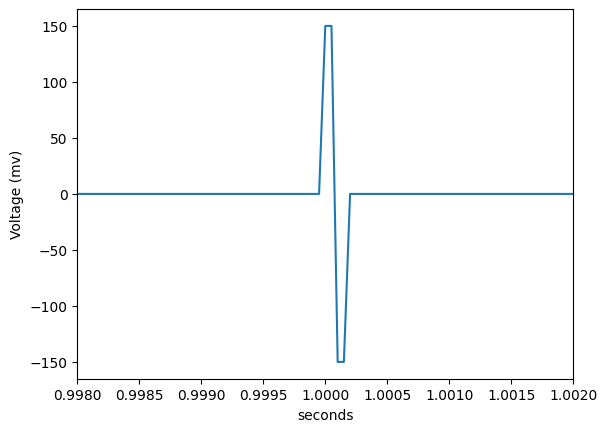

In [12]:
t,signal =  getTimeSignal(60)
signal = squareWave( signal, time_s=1, phase_us=200, amp_mV=150 )

plt.plot(t,signal)
plt.xlim([.998,1.002])
plt.xlabel('seconds')
plt.ylabel('Voltage (mv)')
plt.show()

# Sequence Creater

In [13]:
def insert_square_wave_advanced(sig,time,phase_length=20, amplitude=1):
    '''Deflects positively at *time* for 20 samples (1ms) then deflects negatively for 20 samples, 
    then returns to normal'''
    sig[time:time+phase_length] = amplitude
    sig[time+phase_length:time+phase_length*2] = -amplitude
    return sig

In [27]:
stim_pattern = []
stim_pattern.append(('stim',[0],150,200))
stim_pattern.append(('delay',200))
stim_pattern.append(('stim',[1],200,200))
stim_pattern.append(('delay',250))
stim_pattern.append(('stim',[0,1,2],150,200))



def create_stim_pulse_sequence(stim_list, freq_Hz=None, time_arr = None,max_time_s = 1):
    """
    Creates a stim pulse sequence, parallels the real code that will run on the Maxwell
    
    Params:
    stim_list - list of tuples indicating the commands to run
            ------------------------------------------------
            For 'stim' command:
            ('stim', [neuron inds], mv, us per phase)

            For 'delay'
            ('delay', frames_delay)
            
            For 'next'
            ('next', None)
            This command acts as a placeholder to move to the next timepoint in the time_arr or the next
            period triggered by the freq_Hz
            -------------------------------------------------
    freq_Hz - frequency to call the top stim_list in
            *Note* this takes priority over time_arr
    time_arr - array of time values that will be when the stimulations occur in order
    
    max_time_s - time in seconds to stimulate
    
    
    Returns:
    sig - np.array -- shape=(n_neurons, timesteps) of what the signal will look like
    t - np.array   -- shape=(timesteps) of time in seconds
    """
    
    # Since this is fake, only parallels the code on the device,
    # We have to make our own time
    # And simulate what the stimulation will look like
    
    # Conversion paramerters
    fs_ms = 20 # Good for converting frames to ms
    fs_us = .2
    
    # stim list
    seq = ('next',None)
    stim_list.append(seq)
    stim_list=stim_list*freq_Hz
    
    # Setup
    fs = 20000
    n_neurons = 3
    t = np.arange(0,fs*max_time_s)/fs
    sig = np.zeros(shape=(n_neurons,t.shape[0]))
    
    
    # This would be generated in *real time*
    if freq_Hz is not None:
        # Until the time is right to stimulation the sequence
        for time in t[::fs//freq_Hz]:
            time_frames = int(time*fs)
            
            
            if len(stim_list) == 0:
                return sig
            
            #Build the sequence
            command = None
            
            while (command != 'next'):
                command, *params = stim_list.pop(0) # Get first thing off list
                if command == 'stim':
                    neurons, amplitude, phase_length = params
                    phase_length = int(phase_length*fs_us)
                    
                    # Change signal for each neuron
                    for n in neurons:
                        sig[n,:] = insert_square_wave_advanced(sig[n,:],time_frames,phase_length, amplitude=amplitude)
                    time_frames += phase_length*2
                    
                if command == 'delay':
                    time_frames += fs_ms*params[0]
                    
                #double checking here
                if command == 'next':
                    break 
                    
        return sig,t
                    





    

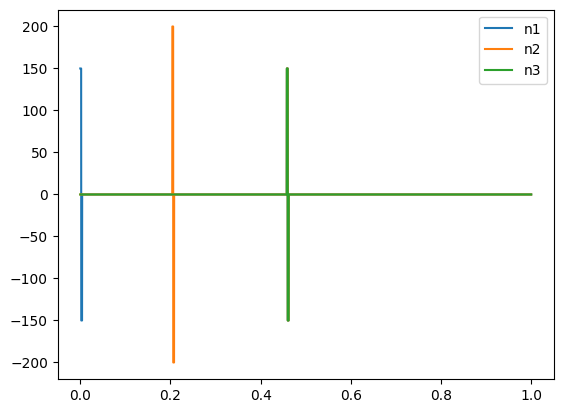

In [28]:
sig,t = create_stim_pulse_sequence(stim_list, freq_Hz=1)

plt.plot(t,sig.T)
plt.legend(['n1','n2','n3'])
plt.show()

# <font color="brown">Old Junk

In [ ]:
# Generate a stimulation waveform

fs = 20000 # samples per second

t = np.arange(0,fs*60)/fs
print('Shape of t', t.shape)

# Imagine we have zero signal, same shape as t
sig = np.zeros_like(t)
print('Shape of sig', sig.shape)

plt.plot(t,sig) # this is boring, but we will build
plt.show()



In [ ]:
# Now we want to build a square wave, where it is positive first, then negative, lets 
# make a function that does that starting at a specific timepoint in t

def insert_square_wave(sig,time):
    '''Deflects positively at *time* for 20 samples (1ms) then deflects negatively for 20 samples, 
    then returns to normal'''
    sig[time:time+20] = 1
    sig[time+20:time+40] = -1
    return sig

t = np.arange(0,fs*60)/fs
sig = np.zeros_like(t)

sig2 = insert_square_wave(sig,1*fs) #insert it 1s in

plt.plot(t,sig2)
plt.xlim([0,2])
plt.xlabel('seconds')
plt.ylabel('amplitude')
plt.show()

# Well we may need to zoom more, remember this is *tiny*, we are in the milliseconds here

plt.plot(t,sig2)
plt.xlim([.99,1.01])# 200ms around the time we inserted
plt.xlabel('seconds')
plt.ylabel('amplitude')
plt.show()

In [ ]:
# Ok that looks good. Well, we should modify the function so we can change the duty cycle (length of the phases)
# Also we want to scale this!

def insert_square_wave_advanced(sig,time,phase_length=20, amplitude=1):
    '''Deflects positively at *time* for 20 samples (1ms) then deflects negatively for 20 samples, 
    then returns to normal'''
    sig[time:time+phase_length] = amplitude
    sig[time+phase_length:time+phase_length*2] = -amplitude
    return sig

# Ok looking better


t = np.arange(0,fs*1)/fs #We do 1 second this time :shrug:
sig = np.zeros_like(t)

sig2 = insert_square_wave_advanced(sig,100,phase_length=8, amplitude=2) #insert it 1s in
sig2 = insert_square_wave_advanced(sig2,200,phase_length=4, amplitude=1)
sig2 = insert_square_wave_advanced(sig2,400,phase_length=100, amplitude=.8)

# Well we may need to zoom more, remember this is *tiny*, we are in the milliseconds here

plt.plot(t,sig2)
plt.xlim([0,.035])# 200ms around the time we inserted
plt.xlabel('seconds')
plt.ylabel('amplitude')
plt.show()

In [ ]:
# Looks good again.
# Well this is how we are going to build stimulation for neural units
# Ash has parsed the literature and tried experiments, and we've settled on voltages aroung 150-200mv 
# Which can evoke neural spikes

# Unless you are doing closed loop experiments (outside of the scope of this, talk to Ash)
# we can create stimulation patterns to stimulate at fixed (or probablistic) intervals!

# First lets see what it looks like if our previous pattern occurs at a fixed frequency

t = np.arange(0,fs*3)/fs #We do 3 second this time
sig = np.zeros_like(t)
freq_Hz = 5 # 5 times per second

for time in t[::fs//freq_Hz]: #This iterates at the proper frequency, don't worry about it!
    
    print('Occuring at', time, 'seconds')
    



In [ ]:
t = np.arange(0,fs*3)/fs #We do 3 second this time
sig = np.zeros_like(t)
sig2 = np.zeros_like(t)
freq_Hz = 20 # 20 times per second

for time in t[::fs//freq_Hz]: #This iterates at the proper frequency, don't worry about it!
    # Oops, we have to go from time in seconds to time in frames
    time_frames = int(time*fs) # We have to index with integers
    
    sig=insert_square_wave_advanced(sig,time_frames)
    
# What do we expect? Hopefully we have 20 squarewaves per second!
plt.plot(t,sig)
plt.show()
    
    
# MORE, lets change the amplitude as it goes, and the frequency!
freq_Hz = 30 # 20 times per second
for time in t[::fs//freq_Hz]: #This iterates at the proper frequency, don't worry about it!
    # Oops, we have to go from time in seconds to time in frames
    time_frames = int(time*fs) # We have to index with integers
    
    sig2=insert_square_wave_advanced(sig2,time_frames,amplitude = np.sin(time*3))
    
# What do we expect? Hopefully we have 20 squarewaves per second!
plt.plot(t,sig)
plt.plot(t,sig2,'g')
plt.show() # Pretty, you can see the aliasing!
    

In [ ]:
# Well, you ask, how does this allow me to stimulate an organoid?

# So hear me out-----
# The maxwell array has 24k+ electrodes!
# We can only record from ~1024
# And stimulate from 32
# However you will only be stimulating from less than 5 electrodes, which we will
# Identify to you as Neurons [0,1,2,3,4]

# Above we played with making waveforms, this new method will be very similar,
# Although it will be able to send the signal to the Maxwell device directly

# There are digital to Analogue converters (DAC)s on this device that can
# Convert signals similar to the one you created into a voltage waveform

# However there is only one that you will be using!

# WAIT, you say, how can we think about stimulating multiple neurons then?

# Well, that's a good question, and thus we have to have a clever solution
# What we'll do is power on/off the stimulation electrodes extremely rapidly
# and with this we can make anything 
# (as long as you don't want 2 different waveforms simultaneously)

# Lets take a look at how this works


In [ ]:
# We can do this a few ways

# ------- FreqEnv
# If we want to use the "FreqEnv" we will send in either a stimulation sequence,
# or a list of stimulation sequences. If it is one sequence, the environment will
# stimulate that pattern at the requested frequency

# If we send in a frequency and a list of sequences, the sequences will be stimulated
# In order or randomly (if using the "random" param)

# One thing to note is that --- max_time <= len(stim_seqs)*freq
# Or in english, you need to have enough stimulations to last the whole time
# -- or else no stimulations will occur

#-------- OtherEnv ------
# To be added




In [ ]:
# How to define a sequence
# --Warning, the length of the sequence should not be longer than the period
# What this means, if you are trying to stimulation 10 times per second (10Hz)
# You cannot create a stimulation pattern that is 1 second long 


# We will be using different code, but the logic is the same



# For 'stim' command:
# ('stim', [neuron inds], amplitude, frames per phase)
# Phase is half a period, 1 frame is 50us

# For 'delay'
# ('delay', frames_delay)
# 1 frames_delay is 50us
# 20 frames_delay is 1ms

# For 'next'
# ('next', None)
# This command acts as a placeholder to move to the next timepoint in the time_arr or the next
# period triggered by the freq_Hz


# Assume we want this pattern
# neuron 0, 150mv, 200us per phase
# 5ms delay
# neuron 1,2, 200mv, 200us per phase
# 20ms delay
# neurons 0-4, 150mv, 200us per phase
# 10ms delay
# Repeat 10 times

stim_list = []
fs_ms = 20 # Good for converting frames to ms
fs_us = .2

seq = ('stim',[0],150,int(200*fs_us)) # Its weird this is in frames, how can this be more human readable
stim_list.append(seq)
seq = ('delay',fs_ms*5)
stim_list.append(seq)

seq = ('stim',[1],200,4)
stim_list.append(seq)
seq = ('delay',fs_ms*20)
stim_list.append(seq)

seq = ('stim',[0,1,2],150,4)
stim_list.append(seq)
seq = ('delay',fs_ms*20)
stim_list.append(seq)

seq = ('next',None)
stim_list.append(seq)

stim_list=stim_list*10 # repeat

# for s in stim_list:
#     print(s)





def _create_stim_pulse_sequence(stim_list, freq_Hz=None, time_arr = None,max_time_s = 1):
    """
    Creates a stim pulse sequence, parallels the real code that will run on the Maxwell
    
    Params:
    stim_list - list of tuples indicating the commands to run
            ------------------------------------------------
            For 'stim' command:
            ('stim', [neuron inds], mv, us per phase)

            For 'delay'
            ('delay', frames_delay)
            
            For 'next'
            ('next', None)
            This command acts as a placeholder to move to the next timepoint in the time_arr or the next
            period triggered by the freq_Hz
            -------------------------------------------------
    freq_Hz - frequency to call the top stim_list in
            *Note* this takes priority over time_arr
    time_arr - array of time values that will be when the stimulations occur in order
    
    max_time_s - time in seconds to stimulate
    
    
    Returns:
    sig - np.array -- shape=(n_neurons, timesteps) of what the signal will look like
    t - np.array   -- shape=(timesteps) of time in seconds
    """
    
    # Since this is fake, only parallels the code on the device,
    # We have to make our own time
    # And simulate what the stimulation will look like
    
    # Setup
    fs = 20000
    n_neurons = 3
    t = np.arange(0,fs*max_time_s)/fs
    sig = np.zeros(shape=(n_neurons,t.shape[0]))
    
    
    # This would be generated in *real time*
    if freq_Hz is not None:
        # Until the time is right to stimulation the sequence
        for time in t[::fs//freq_Hz]:
            time_frames = int(time*fs)
            
            
            if len(stim_list) == 0:
                return sig
            
            #Build the sequence
            command = None
            
            while (command != 'next'):
                command, *params = stim_list.pop(0) # Get first thing off list
                if command == 'stim':
                    neurons, amplitude, phase_length = params
                    
                    # Change signal for each neuron
                    for n in neurons:
                        sig[n,:] = insert_square_wave_advanced(sig[n,:],time_frames,phase_length, amplitude=amplitude)
                    time_frames += phase_length*2
                    
                if command == 'delay':
                    time_frames += params[0]
                    
                #double checking here
                if command == 'next':
                    break 
                    
        return sig,t
                    




sig,t = _create_stim_pulse_sequence(stim_list, freq_Hz=10)

    

In [ ]:

plt.plot(t,sig.T)
plt.legend(['a','b','c'])
plt.show()

In [ ]:
for i in range(3):
    plt.plot(t,sig[i])
    plt.show()